# Pair Trading: Backtest with Backtrader

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
from collections import defaultdict
from dataclasses import dataclass, asdict
from datetime import date
from pathlib import Path
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:

sns.set_style('dark')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
idx = pd.IndexSlice

In [4]:
STORE = 'backtest.h5'

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Pairs Trading Backtest

### Pairs DataClass

In [6]:
@dataclass
class Pair:
    period: int
    s1: str
    s2: str
    size1: float
    size2: float
    long: bool
    hr: float
    p1: float
    p2: float
    pos1: float
    pos2: float
    exec1: bool = False
    exec2: bool = False
    active: bool = False
    entry_date: date = None
    exit_date: date = None
    entry_spread: float = np.nan
    exit_spread: float = np.nan

    def executed(self):
        return self.exec1 and self.exec2

    def get_constituent(self, name):
        if name == self.s1:
            return 1
        elif name == self.s2:
            return 2
        else:
            return 0

    def compute_spread(self, p1, p2):
        return p1 * self.size1 + p2 * self.size2

    def compute_spread_return(self, p1, p2):
        current_spread = self.compute_spread(p1, p2)
        delta = self.entry_spread - current_spread
        return (delta / (np.sign(self.entry_spread) *
                         self.entry_spread))

### PandasData definition

In [7]:
class CustomData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = ['open', 'high', 'low', 'close', 'volume']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Define Trading Strategy

In [8]:
class StatisticalArbitrageCointegration(bt.Strategy):
    params = (('trades', None),
              ('risk_limit', -.2),
              ('verbose', True),
              ('log_file', 'backtest.csv'))

    def __init__(self):
        self.active_pairs = {}
        self.closing_pairs = {}
        self.exposure = []
        self.metrics = []
        self.last_close = {}
        self.cnt = 0
        self.today = None
        self.clear_log()
        self.order_status = dict(enumerate(['Created', 'Submitted', 'Accepted',
                                            'Partial', 'Completed', 'Canceled',
                                            'Expired', 'Margin', 'Rejected']))

    def clear_log(self):
        if Path(self.p.log_file).exists():
            Path(self.p.log_file).unlink()
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow(
                    ['Date', 'Pair', 'Symbol', 'Order #', 'Reason',
                     'Status', 'Long', 'Price', 'Size', 'Position'])

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.date()] + txt.split(','))

    def get_pair_id(self, s1, s2, period):
        return f'{s1}.{s2}.{period}'

    def check_risk_limit(self):
        for pair_id, pair in list(self.active_pairs.items()):
            if pair.active:
                p1 = self.last_close.get(pair.s1)
                p2 = self.last_close.get(pair.s2)
                ret = pair.compute_spread_return(p1, p2)
                if ret < self.p.risk_limit:
                    self.log(f'{pair_id},{pair.s1},{pair.s2},Risk Limit,{ret},')
                    del self.active_pairs[pair_id]
                    self.sell_pair(pair_id, pair)

    def sell_pair(self, pair_id, pair, reason='close'):
        info = {'pair': pair_id, 'type': reason}
        if pair.long:
            o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)
        else:
            o1 = self.buy(data=pair.s1, size=abs(pair.size1), info=info)
            o2 = self.sell(data=pair.s2, size=abs(pair.size2), info=info)
        pair.active = False
        pair.exec1 = pair.exec2 = False
        self.closing_pairs[pair_id] = pair

        self.log(f'{pair_id},{pair.s1},{o1.ref},{reason},Created,{pair.long},,{pair.size1},')
        self.log(f'{pair_id},{pair.s2},{o2.ref},{reason},Created,{pair.long},,{pair.size2},')

    def notify_order(self, order):
        symbol = order.data._name
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            p = order.executed.price
            s = order.executed.size
            order_type = order.info.info['type']
            if order_type in ['open', 'close']:
                pair_id = order.info.info['pair']
                if order_type == 'open':
                    pair = self.active_pairs.get(pair_id)
                else:
                    pair = self.closing_pairs.get(pair_id)
                if pair is None:
                    self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed (missing),,{p},{s},{p * s}')
                    return
                component = pair.get_constituent(symbol)
                if component == 1:
                    pair.p1 = p
                    pair.exec1 = True
                elif component == 2:
                    pair.p2 = p
                    pair.exec2 = True
                if pair.executed():
                    pair.exec1 = False
                    pair.exec2 = False
                    if order_type == 'open':
                        pair.entry_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.entry_date = self.today
                        pair.active = True
                    elif order_type == 'close':
                        pair.exit_spread = pair.compute_spread(p1=pair.p1, p2=pair.p2)
                        pair.exit_date = self.today
                        pair.active = False
                        self.closing_pairs.pop(pair_id)
                self.log(f'{pair_id},{symbol},{order.ref},{order_type},Completed,{pair.long},{p},{s},{p * s}')
            else:
                self.log(f',{symbol},{order.ref},{order_type},Completed,,{p},{s},{p * s}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            order_type = order.info.info['type']
            self.log(f',{symbol},{order.ref},{order_type},{self.order_status[order.status]},,,,')

    def enter_pairs(self, df, long=True):
        for s1, s2, hr, period in zip(df.s1, df.s2, df.hedge_ratio, df.period):
            pair_id = self.get_pair_id(s1, s2, period)
            if self.active_pairs.get(pair_id):
                continue

            p1 = self.last_close[s1]
            p2 = self.last_close[s2]
            if long:
                size1 = self.target_value / p1
                size2 = hr * size1
            else:
                size2 = self.target_value / p2
                size1 = 1 / hr * size2

            pair = Pair(s1=s1, s2=s2, period=period, size1=size1, size2=size2,
                        pos1=p1 * size1, pos2=p2 * size2,
                        hr=hr, long=long, p1=p1, p2=p2, entry_date=self.today)
            info = {'pair': pair_id, 'type': 'open'}
            if long:
                o1 = self.buy(data=s1, size=size1, info=info)
                o2 = self.sell(data=s2, size=abs(size2), info=info)
            else:
                o1 = self.sell(data=pair.s1, size=abs(pair.size1), info=info)
                o2 = self.buy(data=pair.s2, size=abs(pair.size2), info=info)

            self.active_pairs[pair_id] = pair

            self.log(f'{pair_id},{s1},{o1.ref},Open,Created,{long},{p1},{size1},{pair.pos1}')
            self.log(f'{pair_id},{s2},{o2.ref},Open,Created,{long},{p2},{size2},{pair.pos2}')

    def adjust_pairs(self):
        orders = defaultdict(float)
        pairs = defaultdict(list)
        for pair_id, pair in self.active_pairs.items():
            p1, p2 = self.last_close[pair.s1], self.last_close[pair.s2]
            pos1, pos2 = pair.size1 * p1, pair.size2 * p2

            if pair.long:
                target_size1 = self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
                target_size2 = pos2 / pos1 * self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
            else:
                target_size2 = self.target_value / p2
                orders[pair.s2] += target_size2 - pair.size2
                target_size1 = pos1 / pos2 * self.target_value / p1
                orders[pair.s1] += target_size1 - pair.size1
            pair.size1 = target_size1
            pair.size2 = target_size2
            pairs[pair.s1].append(pair_id)
            pairs[pair.s2].append(pair_id)

        for symbol, size in orders.items():
            info = {'pairs': pairs[symbol], 'type': 'adjust'}
            if size > 0:
                order = self.buy(symbol, size=size, info=info)
            elif size < 0:
                order = self.sell(symbol, size=abs(size), info=info)
            else:
                continue
            self.log(f',{symbol},{order.ref},Adjust,Created,{size}')

    def prenext(self):
        self.next()

    def next(self):
        self.today = pd.Timestamp(self.datas[0].datetime.date())
        if self.today not in self.p.trades.index:
            return
        self.cnt += 1

        pf = self.broker.get_value()
        cash = self.broker.get_cash()

        exp = {d._name: pos.size for d, pos in self.getpositions().items() if pos}
        self.last_close = {d._name: d.close[0] for d in self.datas}
        exposure = pd.DataFrame({'price'   : pd.Series(self.last_close),
                                 'position': pd.Series(exp)}).replace(0, np.nan).dropna()
        exposure['value'] = exposure.price * exposure.position
        positions = exposure.value.to_dict()
        positions['date'] = self.today
        positions['cash'] = cash
        if not exposure.empty:
            self.exposure.append(positions)
            long_pos = exposure[exposure.value > 0].value.sum()
            short_pos = exposure[exposure.value < 0].value.sum()
            for symbol, row in exposure.iterrows():
                self.log(f',{symbol},,Positions,Log,,{row.price},{row.position},{row.value}')
        else:
            long_pos = short_pos = 0

        trades = self.p.trades.loc[self.today]
        if isinstance(trades, pd.Series):
            trades = trades.to_frame().T

        close = trades[trades.side == 0].sort_values('period')
        for s1, s2, period in zip(close.s1, close.s2, close.period):
            pair_id = self.get_pair_id(s1, s2, period)
            pair = self.active_pairs.pop(pair_id, None)
            if pair is None:
                self.log(f'{pair_id},,,Close Attempt,Failed,,,,')
                continue
            self.sell_pair(pair_id, pair)

        if len(self.active_pairs) > 0:
            self.check_risk_limit()

        long = trades[trades.side == 1]
        short = trades[trades.side == -1]
        if long.empty and short.empty: return
        target = 1 / (len(long) + len(short) + len(self.active_pairs))
        self.target_value = pf * target
        metrics = [self.today, pf, pf - cash, cash, len(exposure), len(self.active_pairs), long_pos, short_pos,
                   target, self.target_value, len(long), len(short), len(close)]
        self.metrics.append(metrics)
        if self.cnt % 21 == 0:
            holdings = pf - cash
            msg = f'PF: {pf:11,.0f} | Net: {holdings: 11,.0f} | # Pos: {len(exposure):3,.0f} | # Pairs: {len(self.active_pairs):3,.0f} | '
            msg += f'Long: {long_pos: 10,.0f} | Short: {short_pos: 10,.0f}'
            print(self.today, msg)

        self.adjust_pairs()

        if not long.empty:
            self.enter_pairs(long, long=True)

        if not short.empty:
            self.enter_pairs(short, long=False)

### Load Trades

In [9]:
trades = pd.read_hdf(STORE, 'pair_trades').sort_index()
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124100 entries, 2017-01-03 to 2019-12-18
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   s1           124100 non-null  object 
 1   s2           124100 non-null  object 
 2   hedge_ratio  124100 non-null  float64
 3   period       124100 non-null  int64  
 4   pair         124100 non-null  int64  
 5   side         124100 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.6+ MB


In [11]:
trade_dates = np.unique(trades.index)
start = trade_dates.min()
end = trade_dates.max()
traded_symbols = pd.concat([trades.s1, trades.s2]).unique()

### Load Prices

In [12]:
prices = (pd.read_hdf(STORE, 'prices')
          .sort_index()
          .loc[idx[traded_symbols, str(start):str(end)], :])

In [13]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 226784 entries, ('AA.US', Timestamp('2017-01-03 00:00:00')) to ('RF.US', Timestamp('2019-12-18 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    226784 non-null  float64
 1   high    226784 non-null  float64
 2   low     226784 non-null  float64
 3   close   226784 non-null  float64
 4   volume  226784 non-null  float64
dtypes: float64(5)
memory usage: 9.9+ MB


### Configure Cerebro

In [14]:
cerebro = bt.Cerebro()
cash = 1000000
cerebro.broker.setcash(cash)

### Add Data

In [15]:
for symbol in traded_symbols:
    df = prices.loc[idx[symbol, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = CustomData(dataname=df)
    cerebro.adddata(bt_data, name=symbol)

### Add Strategy & Analyzer

In [16]:
cerebro.addstrategy(StatisticalArbitrageCointegration,
                    trades=trades, verbose=True,
                    log_file='bt_log.csv')

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

### Run Strategy

In [17]:
start = time()
results = cerebro.run()

ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f} | Duration: {format_time(duration)}')

2017-02-01 00:00:00 PF:   1,010,713 | Net:      -7,599 | # Pos: 267 | # Pairs: 248 | Long:    796,438 | Short:   -804,037
2017-03-03 00:00:00 PF:   1,025,460 | Net:      39,830 | # Pos: 271 | # Pairs: 190 | Long:    792,816 | Short:   -752,986
2017-04-03 00:00:00 PF:   1,023,875 | Net:      56,127 | # Pos: 288 | # Pairs: 585 | Long:    809,129 | Short:   -753,001
2017-05-03 00:00:00 PF:   1,026,397 | Net:      66,258 | # Pos: 284 | # Pairs: 250 | Long:    870,213 | Short:   -803,955
2017-06-02 00:00:00 PF:   1,011,967 | Net:      67,860 | # Pos: 277 | # Pairs: 211 | Long:    817,251 | Short:   -749,391
2017-07-03 00:00:00 PF:   1,001,576 | Net:      65,207 | # Pos: 286 | # Pairs: 170 | Long:    797,097 | Short:   -731,890
2017-08-02 00:00:00 PF:   1,022,790 | Net:      41,928 | # Pos: 298 | # Pairs: 383 | Long:    723,477 | Short:   -681,549
2017-08-31 00:00:00 PF:   1,033,855 | Net:      -4,490 | # Pos: 292 | # Pairs: 106 | Long:    893,082 | Short:   -897,572
2017-10-02 00:00:00 PF: 

### Get PyFolio Inputs

In [18]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [19]:
returns.to_hdf(STORE, 'returns')
positions.to_hdf(STORE, 'positions')
transactions.to_hdf(STORE, 'transactions/')
gross_lev.to_hdf(STORE, 'gross_lev')

### Get Positions

The PyFolio integration is somewhat broken due to API changes after version 0.5.1 so we need to retrieve the positions manually.

In [20]:
traded_pairs = pd.DataFrame(results[0].exposure)
traded_pairs.date = pd.to_datetime(traded_pairs.date)
traded_pairs = traded_pairs.set_index('date').tz_localize('UTC')
traded_pairs.to_hdf(STORE, 'traded_pairs')
traded_pairs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 738 entries, 2017-01-04 00:00:00+00:00 to 2019-12-18 00:00:00+00:00
Columns: 305 entries, AA.US to cash
dtypes: float64(305)
memory usage: 1.7 MB


### Get Metrics

In [21]:
metrics = pd.DataFrame(results[0].metrics,
                       columns=['date', 'pf', 'net_holdings', 'cash',
                                'npositions', 'npairs', 'nlong_pos', 'nshort_pos',
                                'target', 'target_val', 'nlong_trades',
                                'nshort_trades', 'nclose_trades'])
metrics.to_hdf(STORE, 'metrics')

## Run PyFolio Analysis

In [22]:
returns = pd.read_hdf(STORE, 'returns')
transactions = pd.read_hdf(STORE, 'transactions/')
gross_lev = pd.read_hdf(STORE, 'gross_lev')
metrics = pd.read_hdf(STORE, 'metrics').set_index('date')

In [23]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 675 entries, 2017-01-03 to 2019-09-30
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pf             675 non-null    float64
 1   net_holdings   675 non-null    float64
 2   cash           675 non-null    float64
 3   npositions     675 non-null    int64  
 4   npairs         675 non-null    int64  
 5   nlong_pos      675 non-null    float64
 6   nshort_pos     675 non-null    float64
 7   target         675 non-null    float64
 8   target_val     675 non-null    float64
 9   nlong_trades   675 non-null    int64  
 10  nshort_trades  675 non-null    int64  
 11  nclose_trades  675 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 68.6 KB


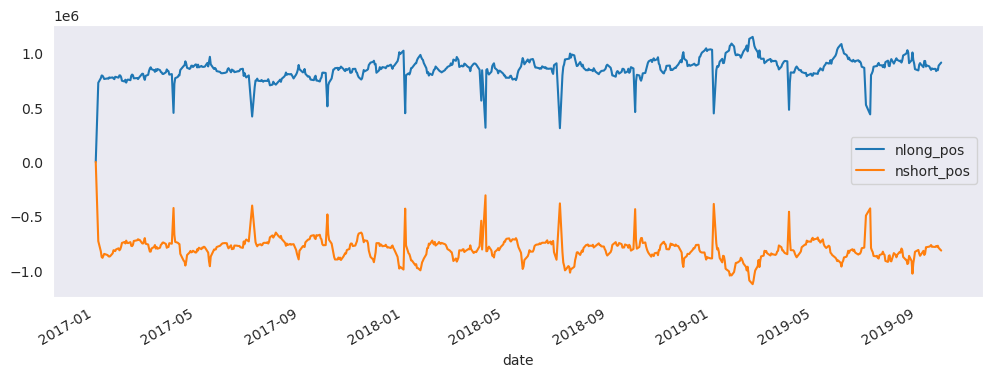

In [24]:
metrics[['nlong_pos', 'nshort_pos']].plot(figsize=(12, 4));

### Get Benchmark

In [25]:
start = str(returns.index.min().year)
end = str(returns.index.max().year + 1)

In [26]:
benchmark = web.DataReader('SP500', 'fred',
                           start=start,
                           end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

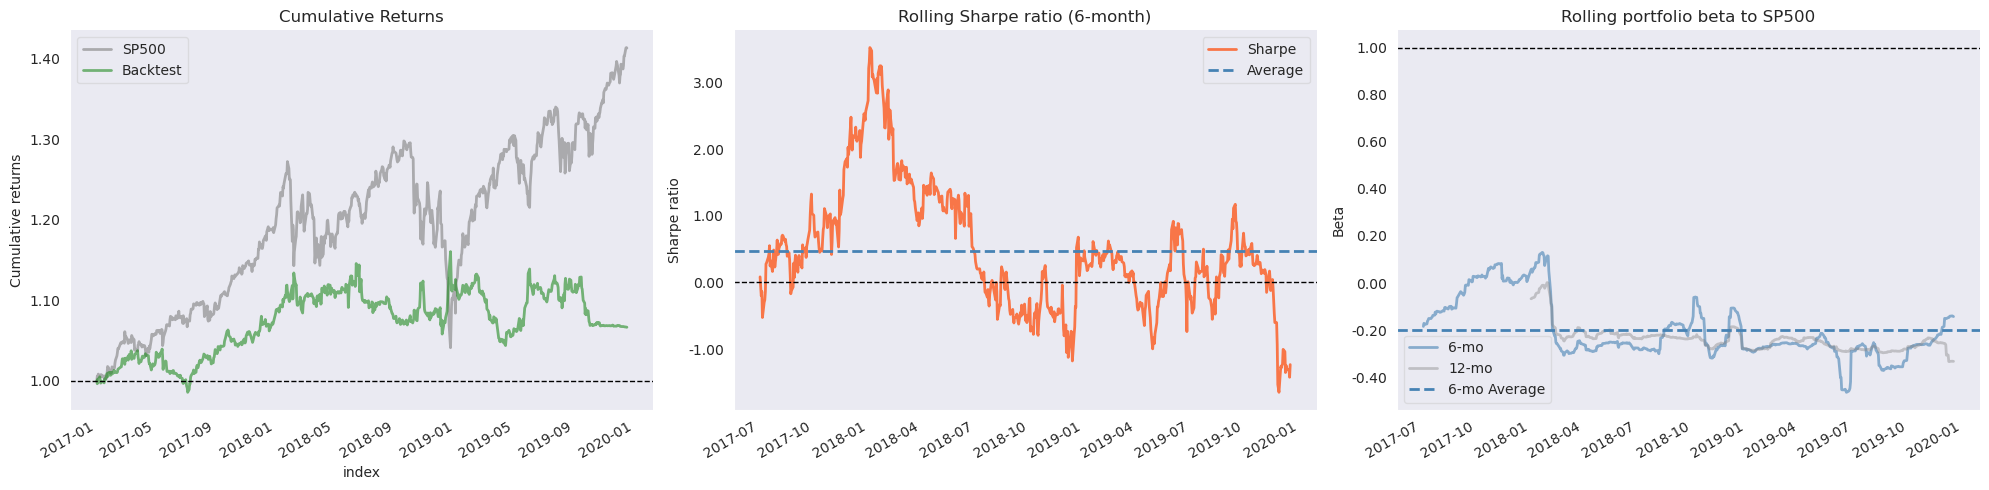

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
pf.plotting.plot_rolling_returns( returns, factor_returns=benchmark, ax=axes[0])
axes[0].set_title('Cumulative Returns')
pf.plotting.plot_rolling_sharpe(returns, ax=axes[1])
pf.plotting.plot_rolling_beta(returns, benchmark, ax=axes[2])
sns.despine()
fig.tight_layout();

### Create full tearsheet

Start date,2017-01-03
End date,2019-12-18
Total months,35
,Backtest
Annual return,2.205%
Cumulative returns,6.671%
Annual volatility,8.627%
Sharpe ratio,0.30
Calmar ratio,0.22
Stability,0.43
Max drawdown,-10.047%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.05,2018-12-24,2019-04-15,NaT,NaN
1,7.64,2018-06-15,2018-12-07,2018-12-24,137
2,5.17,2017-05-16,2017-07-07,2017-09-07,83
3,4.39,2018-02-08,2018-02-26,2018-06-15,92
4,2.31,2017-03-27,2017-04-24,2017-05-16,37


Stress Events,mean,min,max
New Normal,0.02%,-2.92%,2.37%


Top 10 long positions of all time,max
RF.US,5.27%


Top 10 short positions of all time,max
RF.US,-2.83%


Top 10 positions of all time,max
RF.US,5.27%


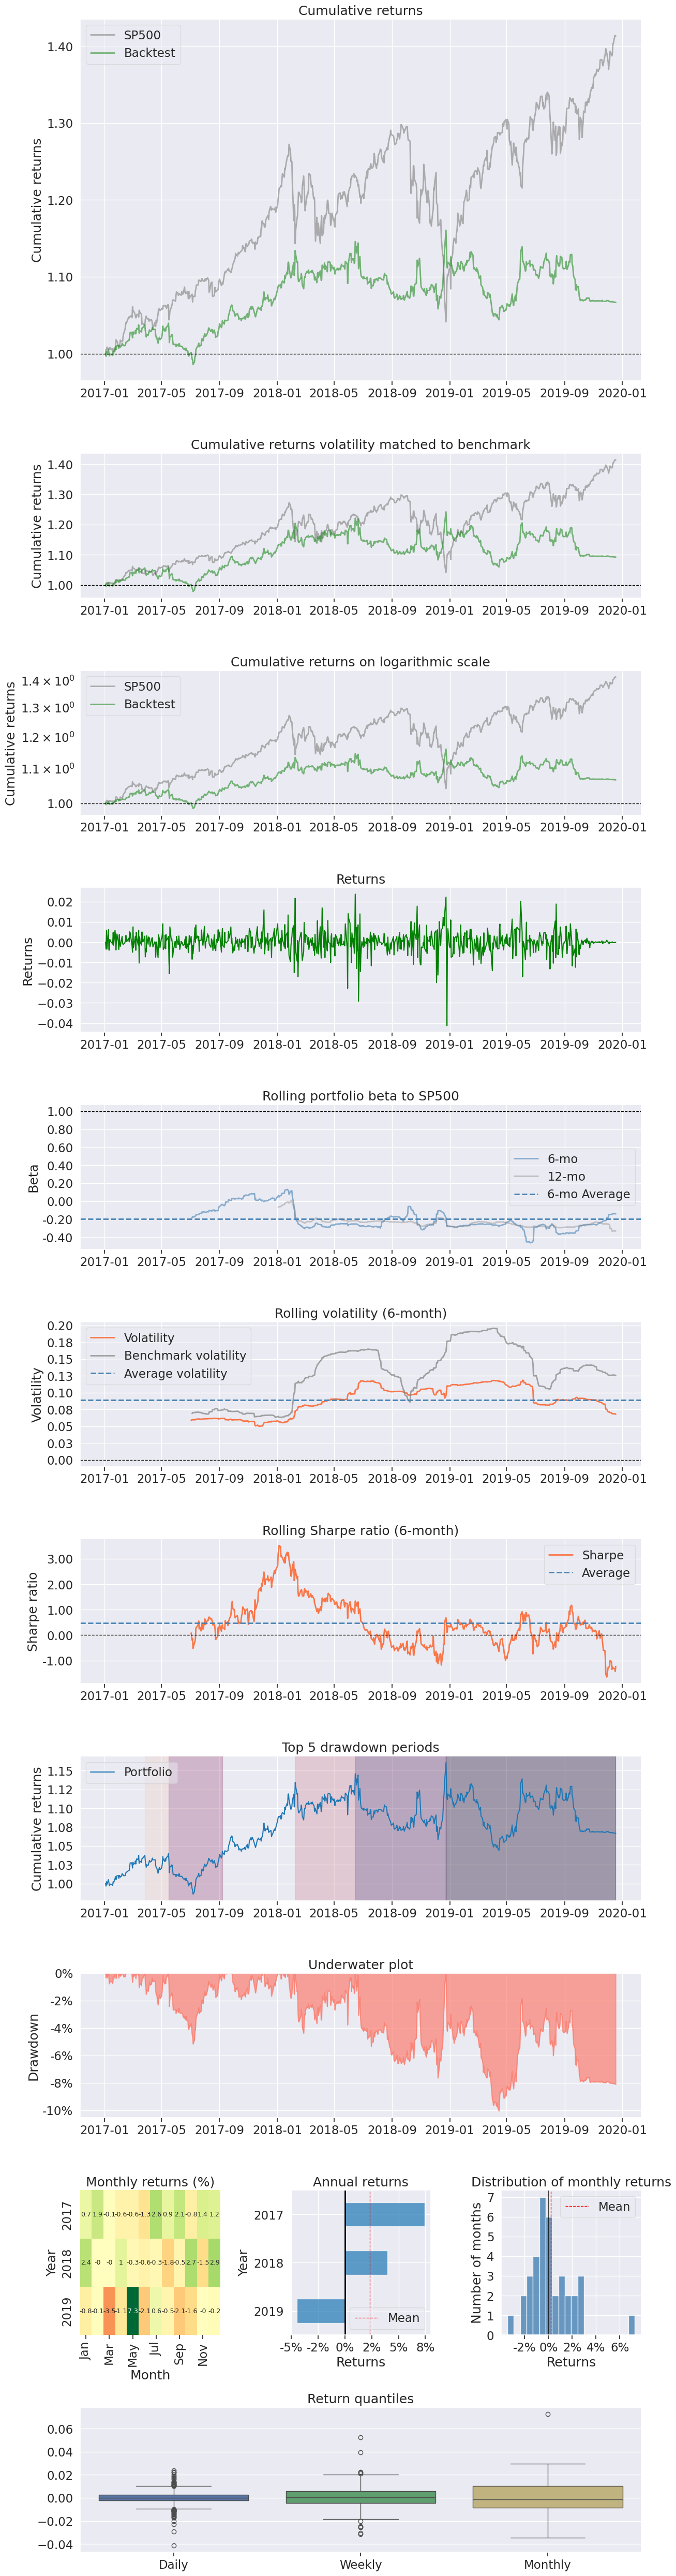

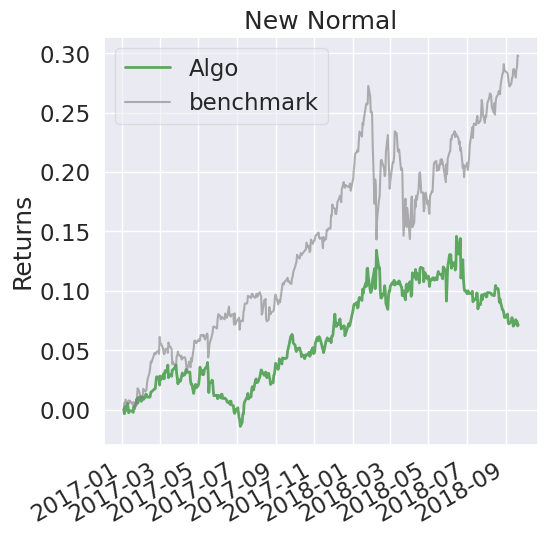

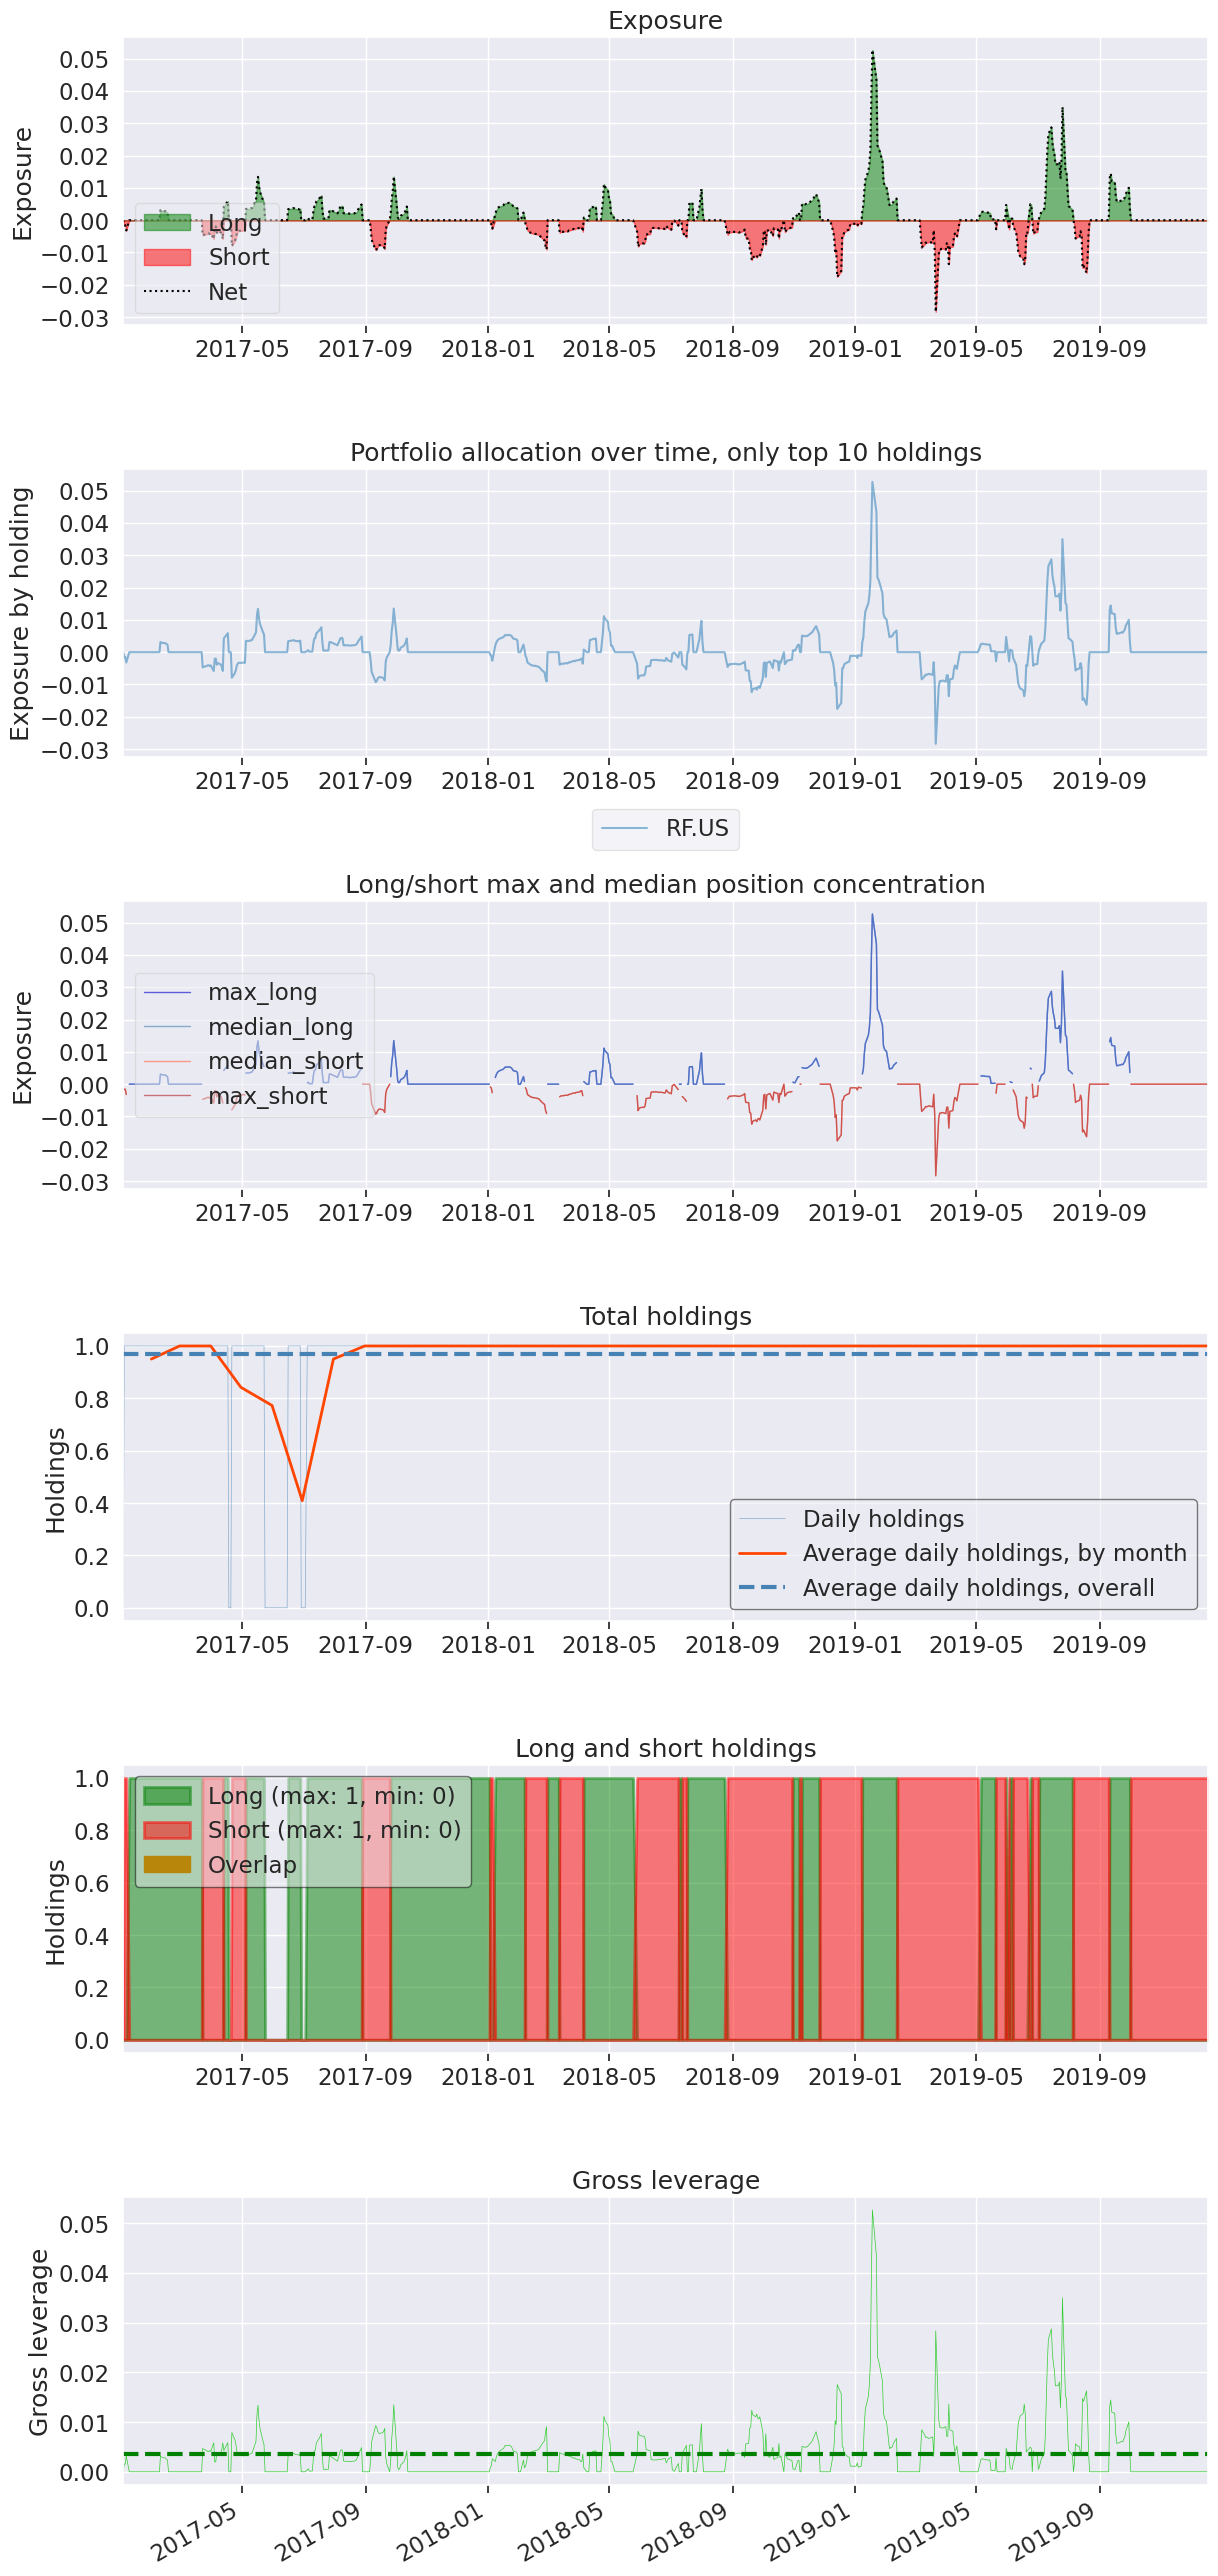

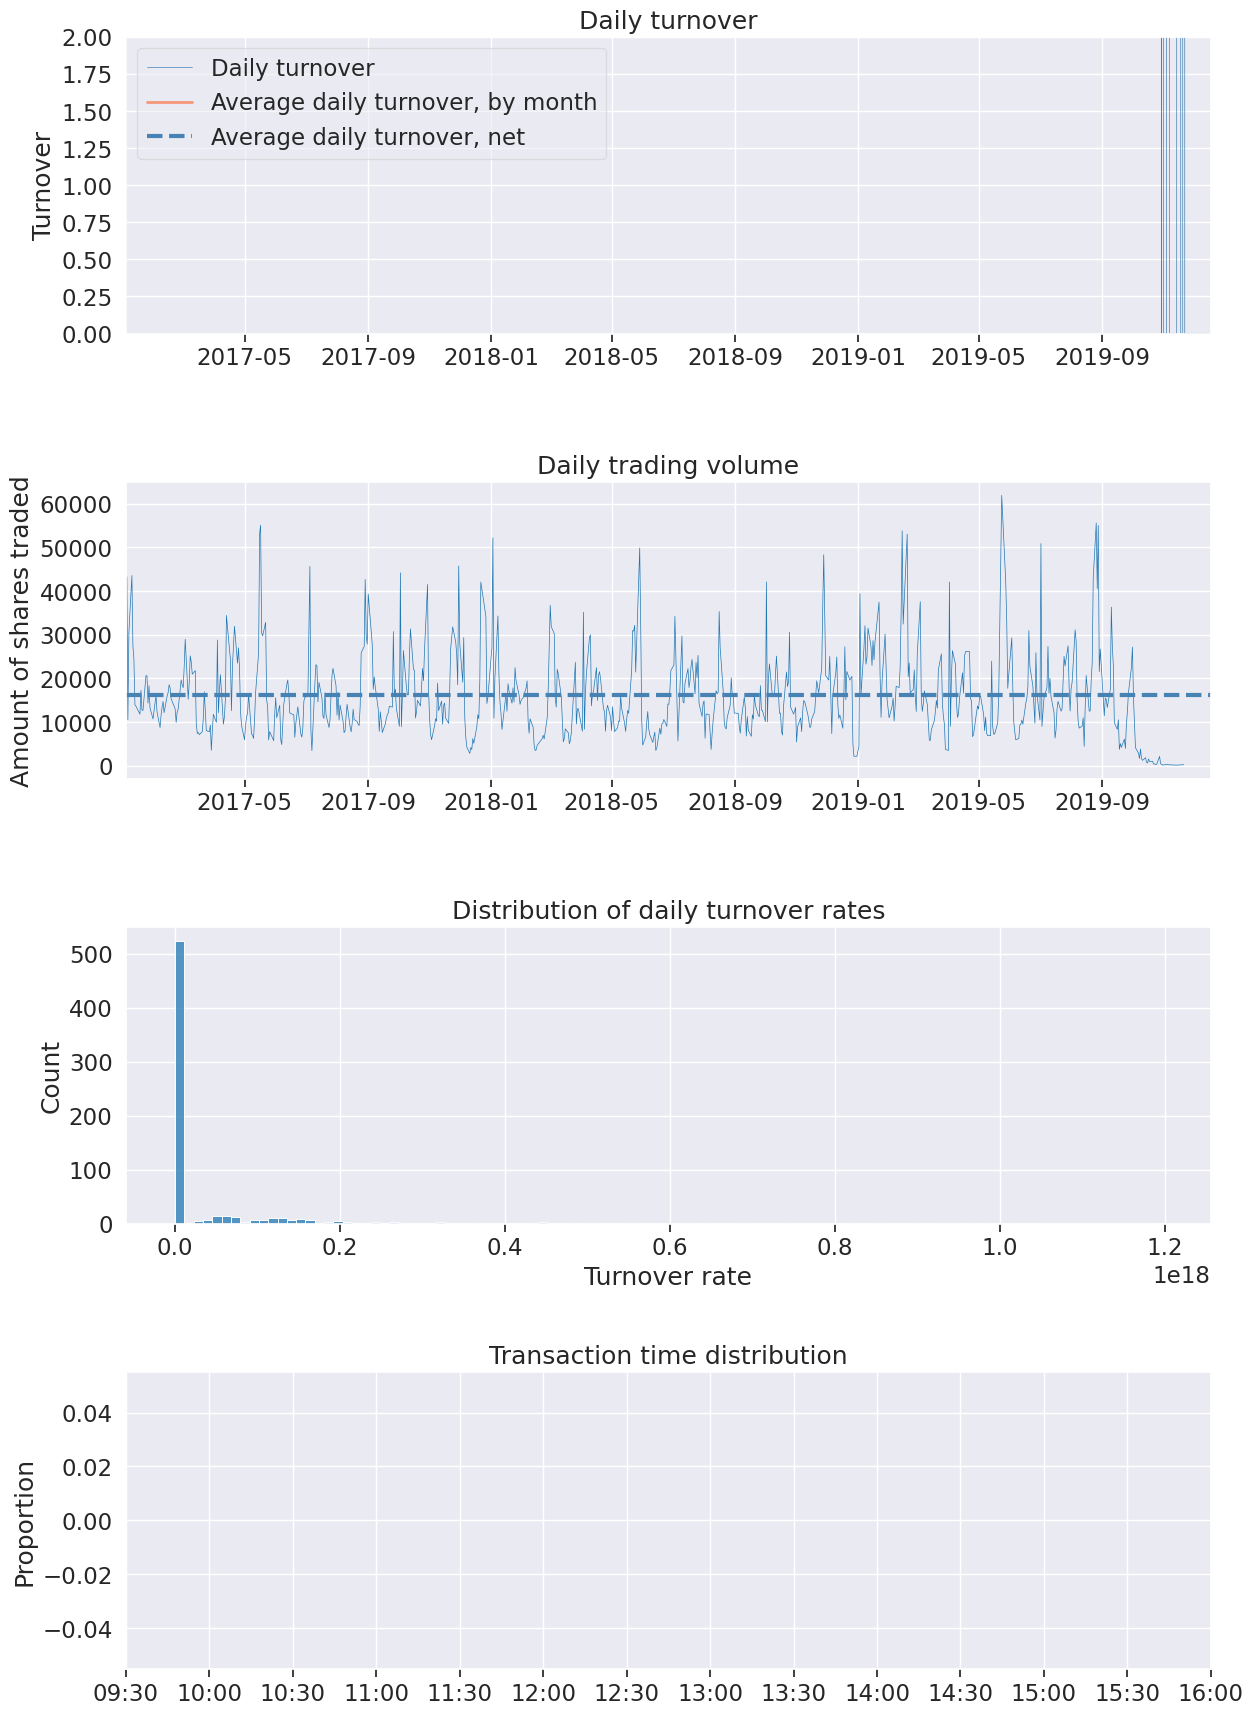

In [28]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark.loc[returns.index],
                          estimate_intraday=False)